#### Imports

In [16]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

print("All libraries are successfully imported!")

All libraries are successfully imported!


#### Extract Dataset

In [5]:
# Read the CSV file
file_path = os.path.join(os.getcwd(), "database.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_pos = df['pos_url']
image_neg = df['neg_url']

new_df = pd.DataFrame({
    'sentence': sentence,
    'image_pos': image_pos,
    'image_neg': image_neg
})

new_df.head()


,sentence,image_pos,image_neg
0,man stand behind the wall,https://previews.123rf.com/images/ryanking999/...,https://previews.123rf.com/images/ryanking999/...
1,The woman is sitting against the wall.,http://www.colourbox.com/preview/5020075-52275...,https://st4.depositphotos.com/1462687/20482/i/...
2,Man doing exercise sits in front of a wall,https://hips.hearstapps.com/hmg-prod.s3.amazon...,https://previews.123rf.com/images/ryanking999/...
3,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8...
4,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://image.shutterstock.com/z/stock-photo-1...


#### Image vectors

In [28]:

def download_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img
   
def extract_features(img):

    img = np.array(img)

    # Load and preprocess the image
    img_data_preprocessed = preprocess_input(img)

    # Extract features
    features = base_model.predict(img_data_preprocessed)

    return img, img_data, features

def pca_image(img, n_components):
    img_path = download_image(img)
    original_img, preprocessed_img, features = extract_features(img_path)

    # Convert original image to numpy array for display
    original_img_array = np.array(original_img)

    # Define the PCA object
    pca = PCA(n_components=n_components)

    replicated_feature_vector = np.tile(features, (n_components, 1))
    pca.fit(replicated_feature_vector)
    reduced_vector = pca.transform(features)

    # print("\nReduced shape:", reduced_vector.shape)
    reshaped_tensor = reduced_vector.reshape(-1)
    # print(f"Reduced Vector: ", reshaped_tensor)

    return reshaped_tensor

def prepare_image(image, n_components):
    #download image
    img = download_image(image)

    # Convert to grayscale 
    if img.mode != 'L':
        img = img.convert('L')
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    print(f"Shape after converting to numpy array: {img_array.shape}")

    # Expand dimensions
    img_data_expanded = np.expand_dims(img_array, axis=0)
    print("Shape of img_data_expanded:", img_data_expanded.shape)  # Should be (1, 224, 224, 3)
    
    img_data_preprocessed = preprocess_input(img_data_expanded)

    print("STOP")

    # Extract features
    features = base_model.predict(img_data_preprocessed)
    print("Shape of features:", features.shape)  
    num_samples, num_features = features.shape
    print("Number of samples:", num_samples)
    print("Number of features:", num_features)

    # Conduct PCA to n components
    pca = PCA(n_components=n_components)
    replicated_feature_vector = np.tile(features, (n_components, 1))
    pca.fit(replicated_feature_vector)
    reduced_vector = pca.transform(features)

    reshaped_tensor = reduced_vector.reshape(-1)

    return reshaped_tensor

# test_image = pca_image(new_df["image_pos"][1], 16)

# feature_vec_pos = pca_image(new_df["image_pos"][1], 16)
# print(f"Feature Vector Positive : {feature_vec_pos}")

# feature_vec_neg = pca_image(new_df["image_neg"][2], 16)
# print(f"Feature Vector Negatice : {feature_vec_neg}")


attempt to pre-process input

In [57]:
def process_image(image, n_components, base_model):
    # Downlaod image
    image = download_image(image)

    image = image.resize((224, 224))

    # Convert the image to an array
    img_array = np.array(image)

    # Expand dimensions to match the shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0))

    # Preprocess the input
    img_array = preprocess_input(img_array)

    # print(f"Raw image data: {img_array}")
    print(f"Image shape: {img_array.shape}")
    # return(img_array)

    # Extract features 
    features = base_model.predict(img_array)

    # # Define the PCA object
    pca = PCA(n_components=n_components)

    features = features.reshape((features.shape[0], -1))

    print(f"Image shape for PCA: {features.shape}")
    replicated_feature_vector = np.tile(features, (n_components, 1))
    pca.fit(replicated_feature_vector)
    reduced_vector = pca.transform(features)

    # # print("\nReduced shape:", reduced_vector.shape)
    reshaped_tensor = reduced_vector.reshape(-1)

    return reshaped_tensor

model = ResNet50(weights='imagenet', include_top=False)
process = process_image(new_df["image_pos"][0], 16, model)

    

SyntaxError: unmatched ')' (1336161183.py, line 11)

In [114]:
copy_df = new_df.copy()
copy_df.loc[1, "image_pos"] = feature_vec_pos
copy_df.head()

,sentence,image_pos,image_neg
0,man stand behind the wall,https://previews.123rf.com/images/ryanking999/...,https://previews.123rf.com/images/ryanking999/...
1,The woman is sitting against the wall.,"[2.5502552e-06, 6.181722e-13, 1.5987212e-13, -...",https://st4.depositphotos.com/1462687/20482/i/...
2,Man doing exercise sits in front of a wall,https://hips.hearstapps.com/hmg-prod.s3.amazon...,https://previews.123rf.com/images/ryanking999/...
3,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8...
4,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://image.shutterstock.com/z/stock-photo-1...


In [124]:
features_df = new_df.iloc[1:3].copy()

# Iterate through each row in the DataFrame
for index, row in features_df.iterrows():
    # Extract the sentence, image_pos, and image_neg from the current row
    sentence_diagram = row['sentence']
    img_pos = row['image_pos']
    img_neg = row['image_neg']

    temp_pos = pca_image(img_pos, 16)
    temp_neg = pca_image(img_neg, 16)

    features_df.loc[index, "image_pos"] = temp_pos
    features_df.loc[index, "image_neg"] = temp_neg

print("Done")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


IndexError: index 1 is out of bounds for axis 3 with size 1

In [121]:
pd.set_option('display.max_colwidth', None)  # or set it to a specific number of characters
features_df.head()

,sentence,image_pos,image_neg
1,The woman is sitting against the wall.,"[2.5502552e-06, 6.181722e-13, 1.5987212e-13, -4.7961635e-14, -4.973799e-14, -1.3216095e-12, 7.1054274e-15, -5.5067062e-14, 8.1712415e-14, -6.994405e-15, -1.498801e-14, -8.1315163e-19, -5.8233515e-22, 2.0162527e-24, 8.4818325e-27, 7.270142e-27]","[2.6603211e-06, -3.419487e-13, 1.314504e-13, 1.16712195e-14, -3.5527137e-15, -9.769963e-15, 0.0, 4.440892e-14, 1.5987212e-14, -1.5785984e-16, 1.263746e-15, 5.007288e-19, -2.5366694e-16, -6.361352e-19, 3.8163916e-17, 1.3183898e-16]"


#### Sentence DisCoCat 

this is in a quantum setting but it might be more efficient in a a tesnor setting

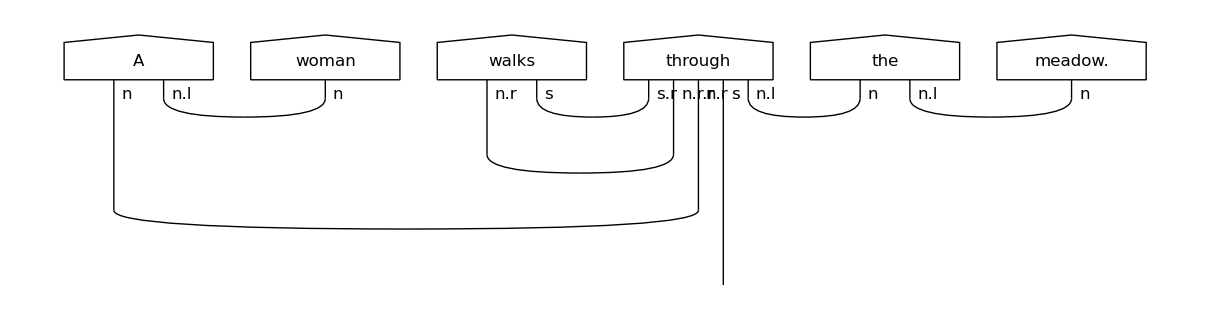

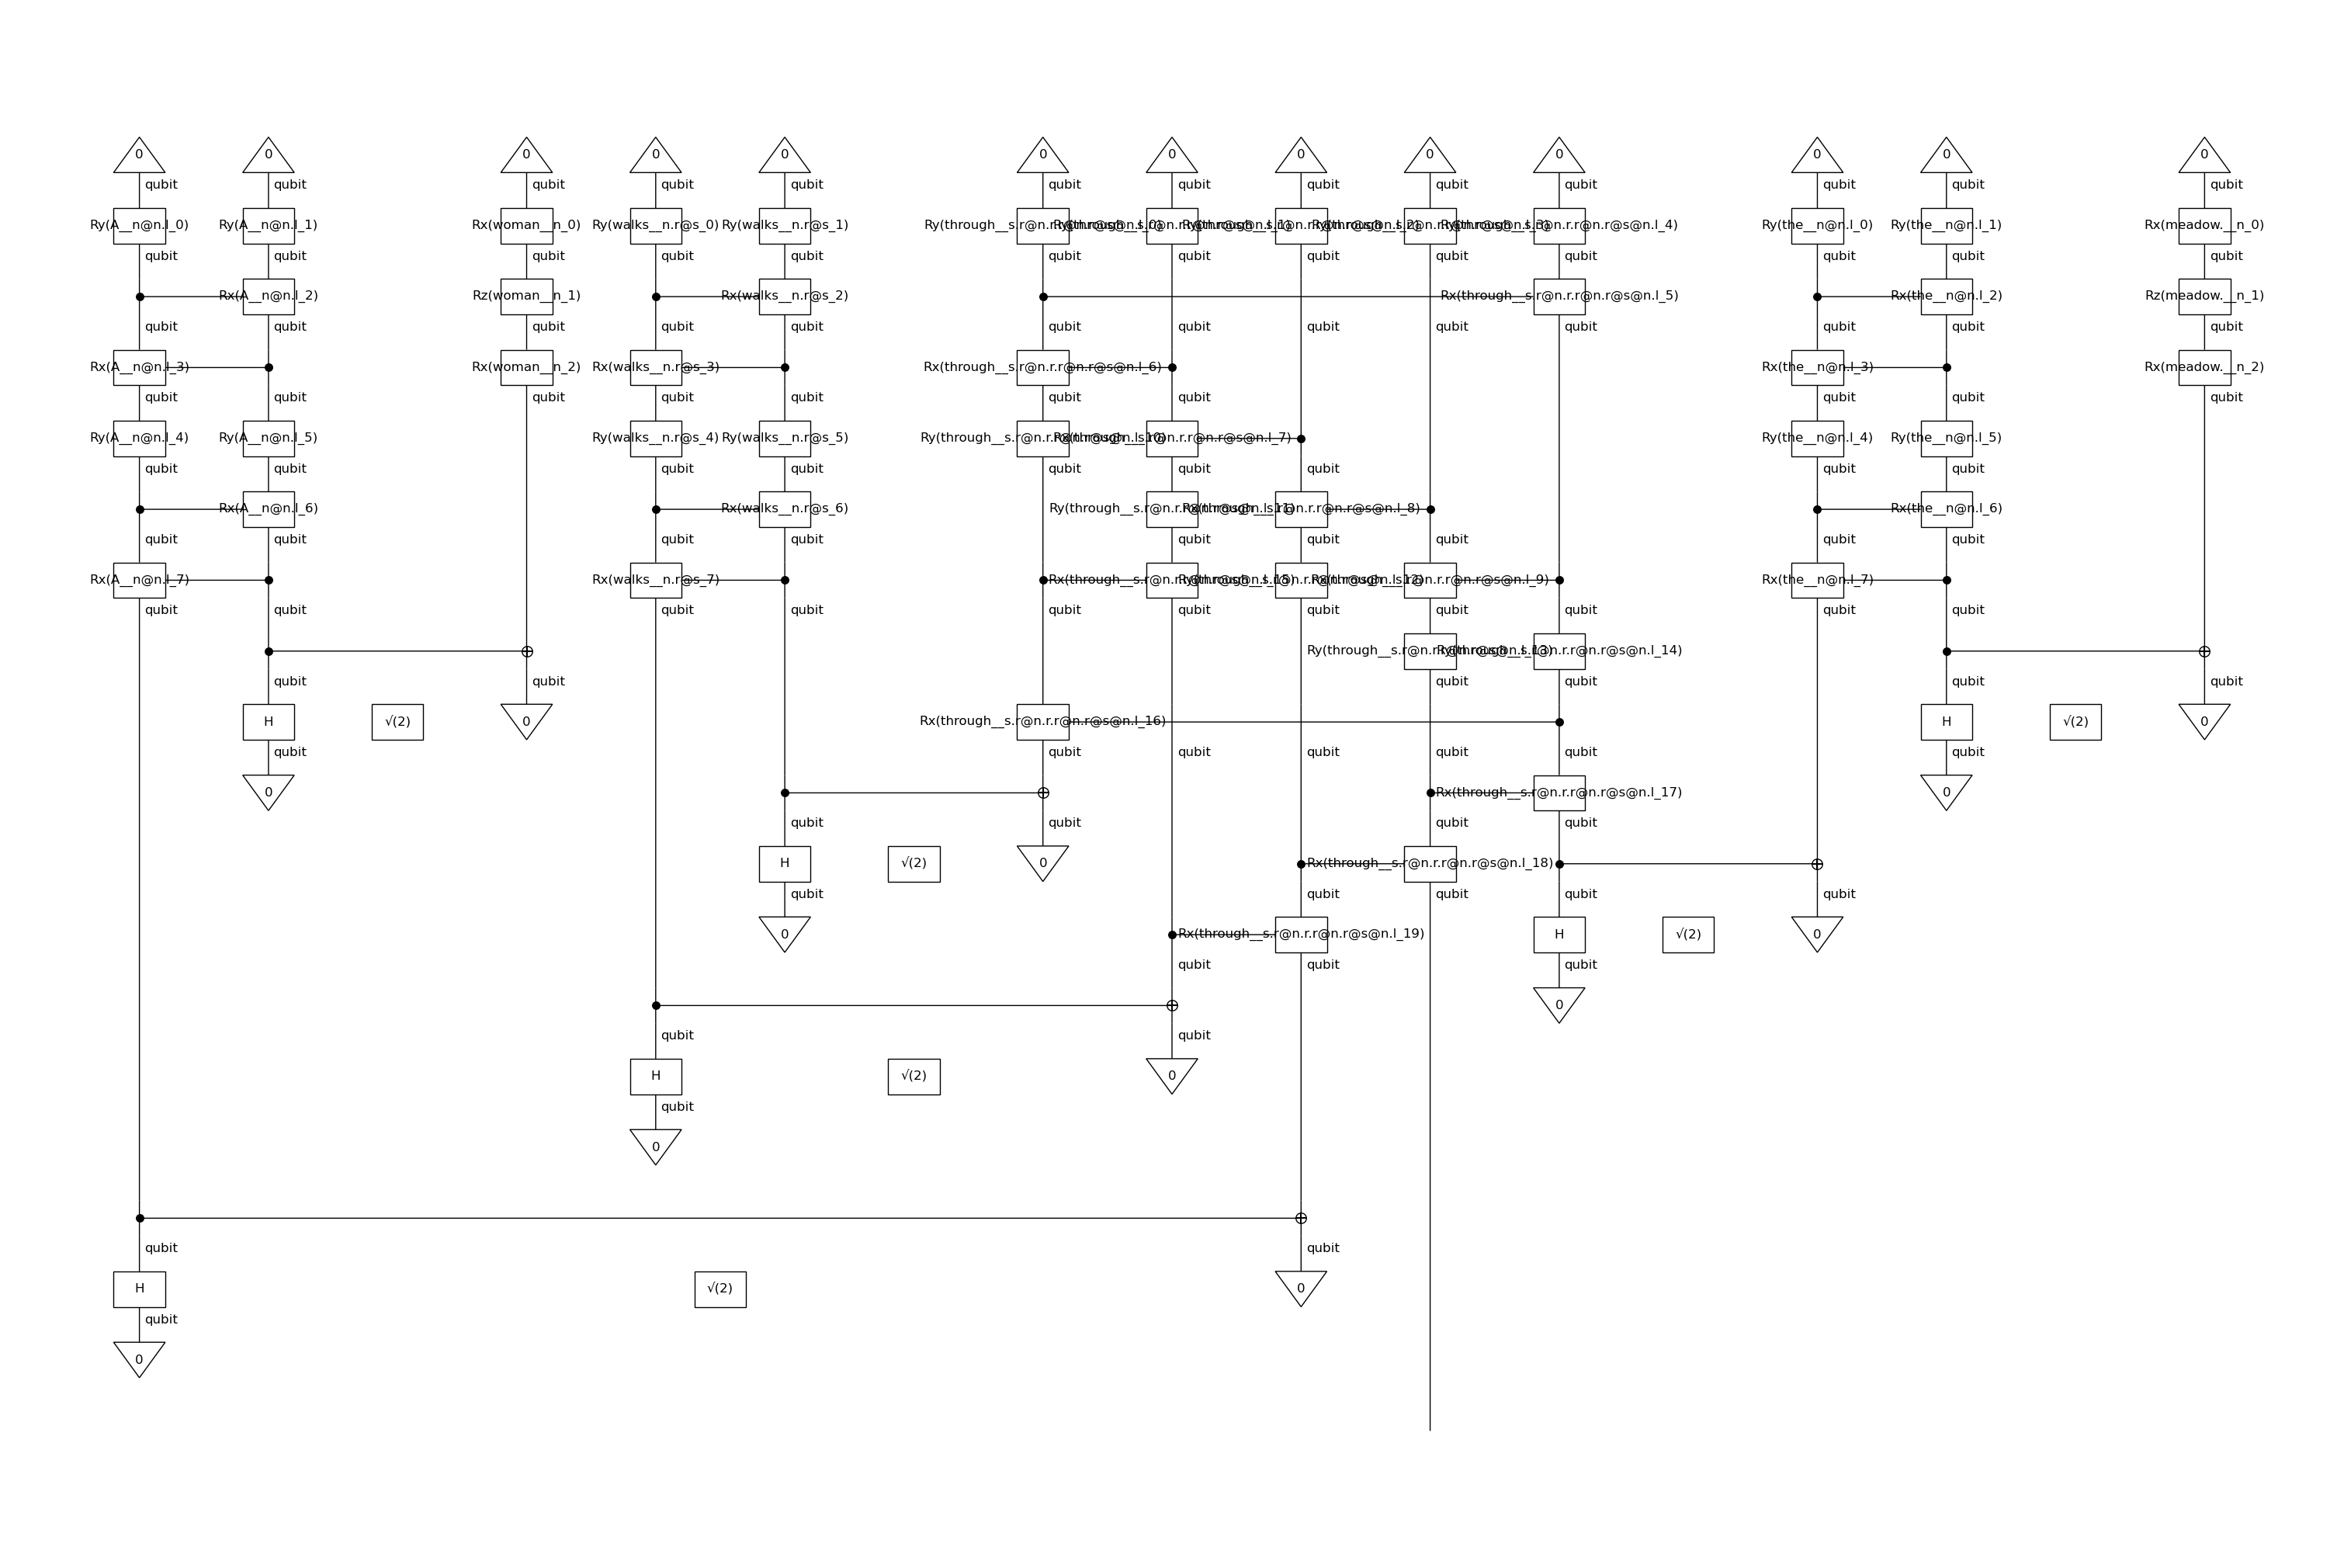

In [11]:
from lambeq import BobcatParser, AtomicType

# Parse the sentence and convert it into a string diagram
sentence = new_df["sentence"][14]

# Use BobbcatParser
parser = BobcatParser(verbose='suppress')
sentence_diagram = parser.sentence2diagram(sentence)
sentence_diagram.draw(figsize=(14, 3), fontsize=12)

ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},n_layers=1)
conc_sentence = ansatz_sentence(sentence_diagram)

conc_sentence.draw(figsize=(30, 20), fontsize=12)

#### Create two seperate ansatz image circuit

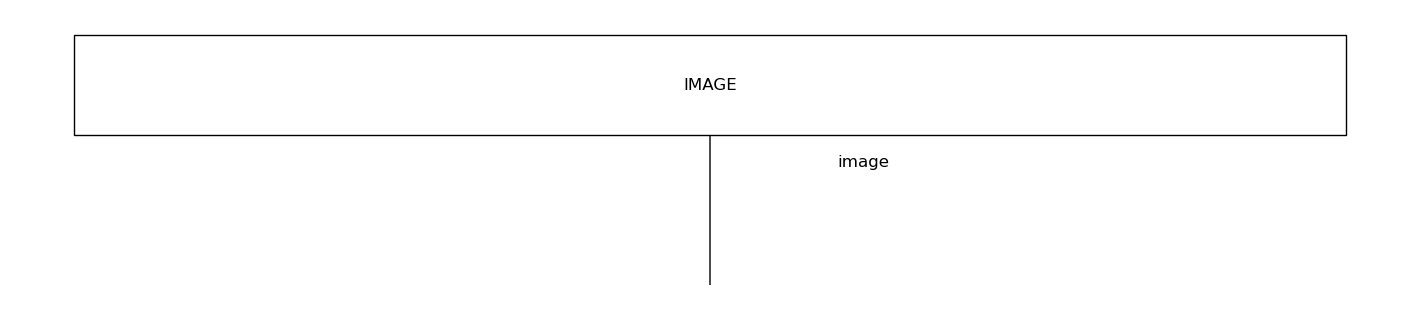

{IMAGE__image_8, IMAGE__image_6, IMAGE__image_10, IMAGE__image_14, IMAGE__image_5, IMAGE__image_3, IMAGE__image_2, IMAGE__image_12, IMAGE__image_15, IMAGE__image_0, IMAGE__image_9, IMAGE__image_4, IMAGE__image_11, IMAGE__image_7, IMAGE__image_1, IMAGE__image_13}
[ 2.5502552e-06  6.1817218e-13  1.5987212e-13 -4.7961635e-14
 -4.9737992e-14 -1.3216095e-12  7.1054274e-15 -5.5067062e-14
  8.1712415e-14 -6.9944051e-15 -1.4988011e-14 -8.1315163e-19
 -5.8233515e-22  2.0162527e-24  8.4818325e-27  7.2701421e-27]


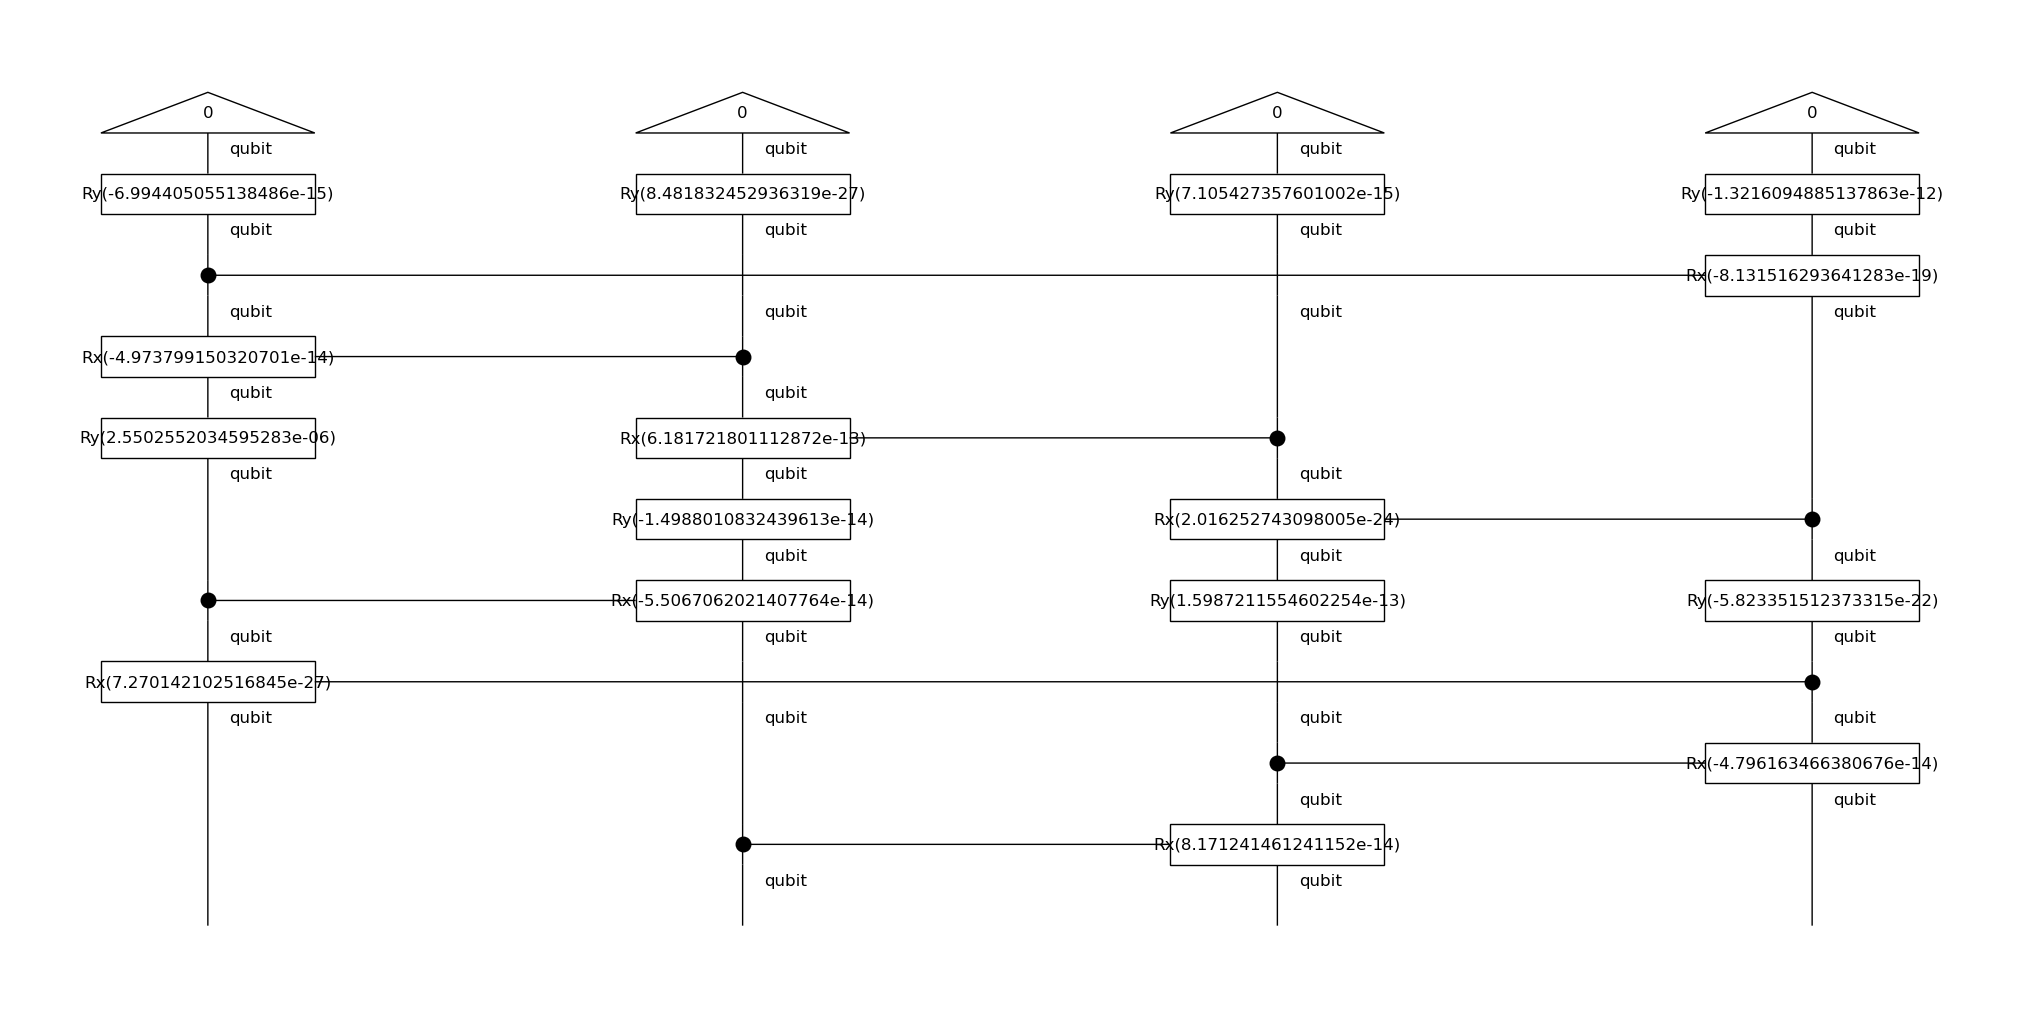

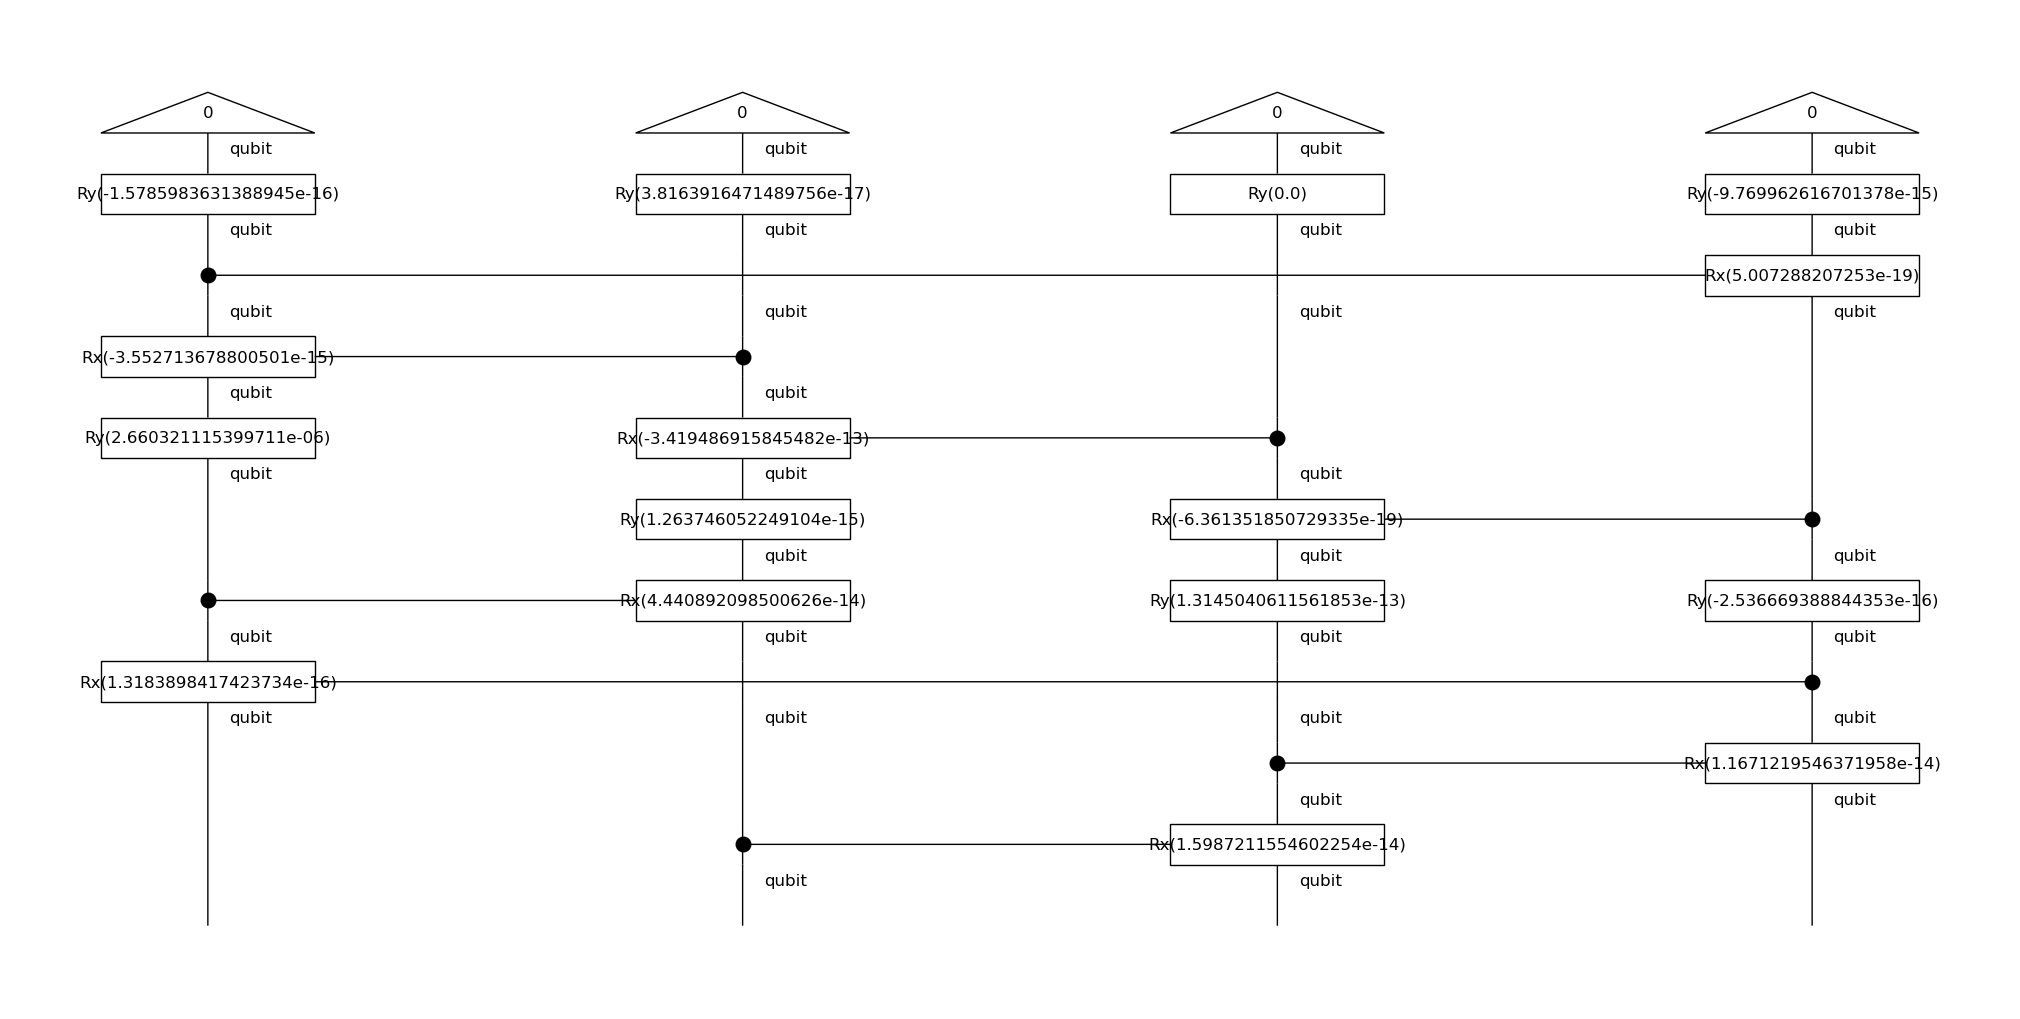

In [64]:
from lambeq.backend.grammar import Ty, Box 
from lambeq import Sim14Ansatz
from torch import nn

# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=1)
image_circ = ansatz(image_box)
# image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POS
conc_image_circ_pos = image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec_pos) 
conc_image_circ_pos.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit NEG
conc_image_circ_neg = image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec_neg) 
conc_image_circ_neg.draw(figsize=(20, 10), fontsize=12)

#### Joined senetnce and image 

Template diagram : (sentence, image1, image2)
Template circuit : (sentence, image_type , image_type)
Quantum circuit : (sentence, image data pos , image data neg)


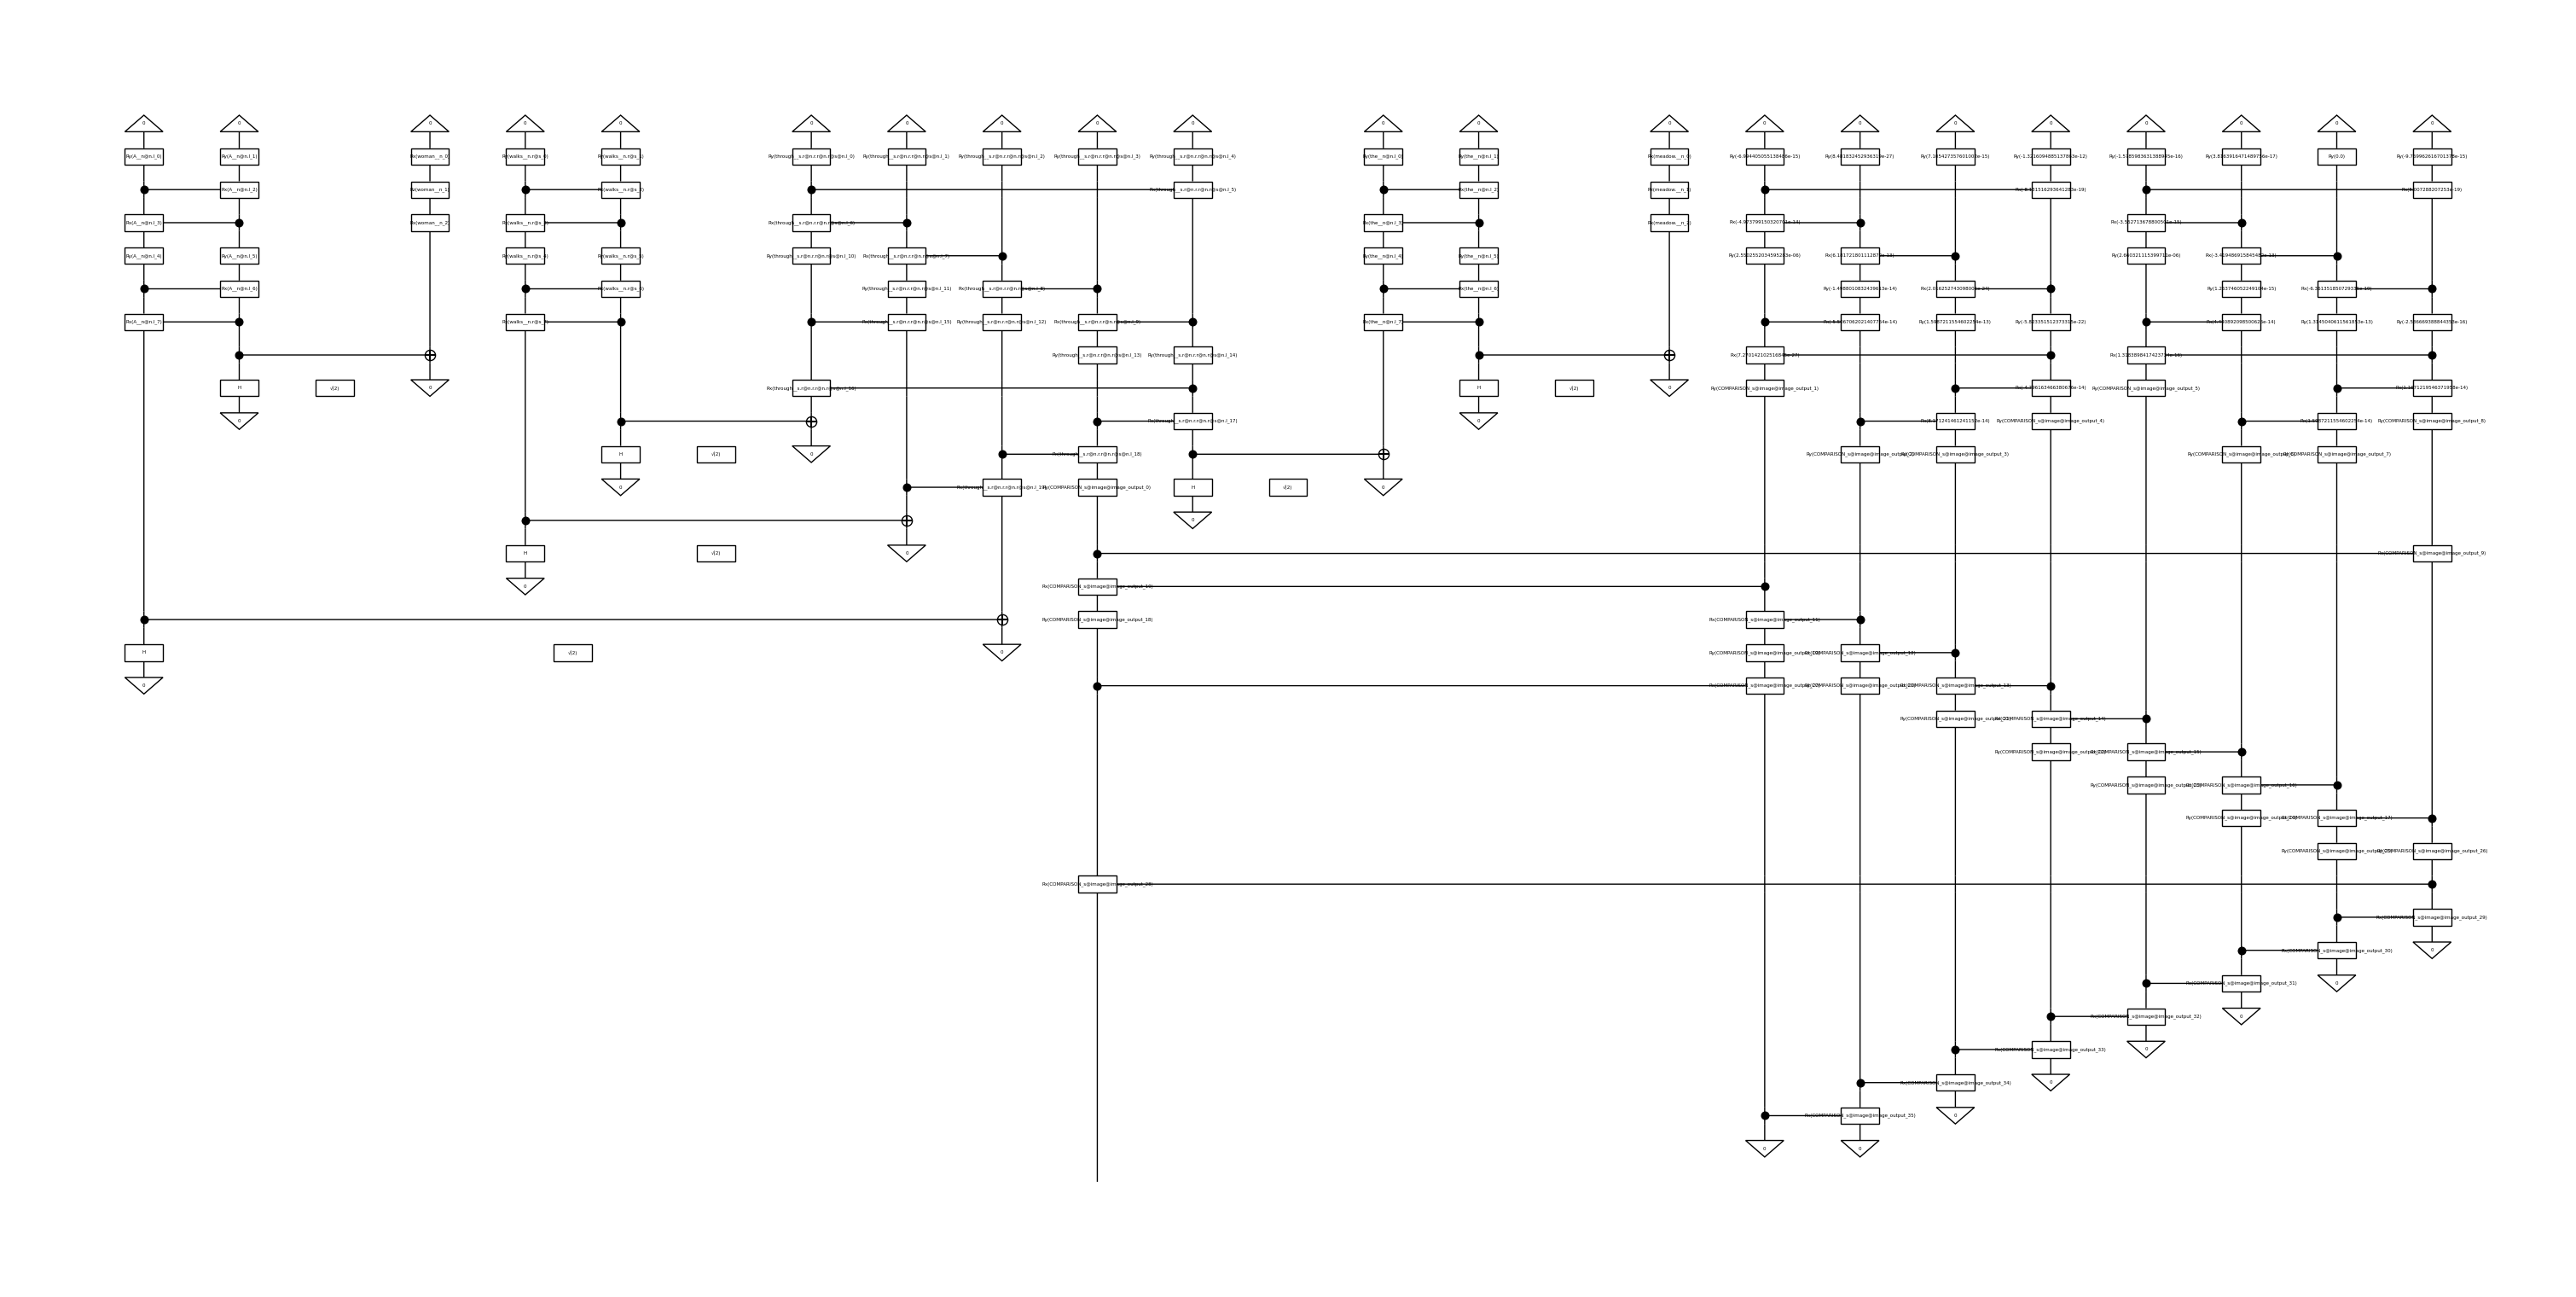

In [100]:
# Create new Type
image_type = Ty("image")
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# Draws diagram with comparison box (0,1)
diagram = (sentence_diagram @ image_type @ image_type) >> comparison_box  # Sentence digarm and comparison box is in grammar form
print("Template diagram : (sentence, image1, image2)")
# temp_diagram.draw(figsize=(20, 10), fontsize=12)

# Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=1)
temp_circuit = ansatz(diagram)
print("Template circuit : (sentence, image_type , image_type)")
# temp_circuit.draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )

image_1 = conc_image_circ_pos
image_2 = conc_image_circ_neg

final_circuit = (image_1 @ image_2) >> circuit
print("Quantum circuit : (sentence, image data pos , image data neg)")
final_circuit.draw(figsize=(30, 15), fontsize=4, draw_type_labels = False )
